<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/GRU_v4%20-Laaj_FE_Soluittain_2025-04-10%2019%3A44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# @title 0. Esitiedot ja Tavoite (GRU v4 - Laaj. FE + Soluittain) (2025-04-10 19:44)
"""
Otsoniennuste Helsinki - GRU-malli v4 (Laajennetulla FE:llä ja Vahvistuksilla)

Tavoite:
1. Ladata data, sisältäen pilvisyyden.
2. Suorittaa laajennettu ominaisuusmuokkaus (FE).
3. Määritellä ja kouluttaa GRU-malli käyttäen laajennettuja ominaisuuksia.
4. Arvioida malli ja analysoida tulokset.
5. Visualisoida.
6. Toimitetaan solu kerrallaan selkeyden ja virheiden minimoimiseksi.
"""
print("--- Osa 0: Esitiedot (GRU v4) - OK ---")

--- Osa 0: Esitiedot (GRU v4) - OK ---


In [107]:
# @title 1. Tuonnit ja Asetukset (Refaktoroitu - GRU) (2025-04-10 19:59) # Päivitetty aika

# Peruskirjastot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import os
import math
import copy
import traceback
import warnings
import time # <--- LISÄTTY IMPORT

# Sklearn
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
except ImportError: raise ImportError("scikit-learn puuttuu.")

# PyTorch
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
except ImportError: raise ImportError("PyTorch puuttuu.")

# Muut
try:
    from tqdm.notebook import tqdm
    import seaborn as sns
except ImportError: tqdm = None; sns = None; print("Tqdm/Seaborn puuttuu.")


# --- Yleisasetukset ---
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
print(f"Käytettävä laite: {device}")

# --- Data-asetukset ---
BASE_GITHUB_URL = 'https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/'
PARQUET_PATH = 'data/processed/processed_Helsinki_O3_Weather_Cloudiness_2024_2025_v3.parquet'
DATA_URL = BASE_GITHUB_URL + PARQUET_PATH
LOCAL_DATA_PATH = 'processed_Helsinki_O3_Weather_Cloudiness_2024_2025_v3.parquet'
TARGET_COLUMN = 'Otsoni [µg/m³]'
BASE_COLUMNS_TO_LOAD = [
    'Otsoni [µg/m³]', 'Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]',
    'Ilmanpaineen keskiarvo [hPa]', 'Tuulen suunnan keskiarvo [°]', 'Pilvisyys [okta]'
]

# --- Ennustus- ja Jakoasetukset ---
FORECAST_HORIZON = 24
SEQUENCE_LENGTH = 72
TEST_SPLIT_RATIO = 0.15
VALID_SPLIT_RATIO = 0.15

# --- RNN/LSTM/GRU Mallin Hyperparametrit ---
RNN_HYPERPARAMS = {
    'model_type': 'GRU',  # Varmistetaan GRU
    'input_size': None,    # Lasketaan myöhemmin
    'hidden_size': 64,
    'num_layers': 2,
    'output_size': FORECAST_HORIZON,
    'dropout_prob': 0.2
}

# --- Neuroverkkojen Koulutusparametrit ---
TRAIN_HYPERPARAMS = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 75,
    'patience': 10
}

# --- Arviointiasetukset ---
O3_THRESHOLD_8H_AVG = 120 # µg/m³

# --- Ajanotto ---
script_start_time = time.time() # <--- LISÄTTY AJANOTON ALOITUS

print("\nOsa 1: Tuonnit ja Asetukset (GRU v4) - SUORITETTU ONNISTUNEESTI.") # Päivitetty vahvistusviesti
print(f"Kohdemuuttuja: {TARGET_COLUMN}")
print(f"Käytettävä RNN-tyyppi: {RNN_HYPERPARAMS['model_type']}")
print(f"8h Keskiarvon kynnysarvo: {O3_THRESHOLD_8H_AVG} µg/m³")

Käytettävä laite: cuda

Osa 1: Tuonnit ja Asetukset (GRU v4) - SUORITETTU ONNISTUNEESTI.
Kohdemuuttuja: Otsoni [µg/m³]
Käytettävä RNN-tyyppi: GRU
8h Keskiarvon kynnysarvo: 120 µg/m³


In [108]:
# @title 2. Funktiot Datan Lataukseen, FE:hen ja Luokittelukohteen Luontiin (GRU Luokittelu v1) (2025-04-10 21:25)

import pandas as pd
import numpy as np
import requests
import io
import os
import re
import traceback
try:
    from sklearn.preprocessing import StandardScaler
except ImportError:
    StandardScaler = None
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except ImportError:
    sns = None; plt = None
# Varmistetaan tqdm tuonti
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = lambda x, **kwargs: x # Korvike, jos tqdm puuttuu
    print("Tqdm puuttuu.")


# --- Funktiot datan lataamiseen (samantyyppiset kuin ennen) ---
def download_data(url, local_path):
    """Lataa tiedoston URL:sta paikalliseen polkuun."""
    try:
        print(f"Yritetään ladata dataa: {url[:60]}...")
        response = requests.get(url); response.raise_for_status()
        target_dir = os.path.dirname(local_path);
        if target_dir and not os.path.exists(target_dir): os.makedirs(target_dir, exist_ok=True)
        with open(local_path, 'wb') as f: f.write(response.content)
        print(f"Data ladattu: {local_path}"); return True
    except Exception as e: print(f"Latausvirhe: {e}"); return False

def load_parquet_data(filepath_or_url, local_cache_path="default_cache.parquet"):
    """Lataa datan Parquet-tiedostosta (paikallisesti tai URL:sta, käyttää välimuistia)."""
    filepath_to_read = None
    # Käytetään globaalia LOCAL_DATA_PATH, jos se on määritelty
    cache_path_to_use = local_cache_path
    if 'LOCAL_DATA_PATH' in globals() and LOCAL_DATA_PATH:
         cache_path_to_use = LOCAL_DATA_PATH

    if filepath_or_url.startswith('http'):
         if os.path.exists(cache_path_to_use): filepath_to_read = cache_path_to_use; print(f"Käytetään välimuistia: {cache_path_to_use}")
         else: print(f"Paikallista tiedostoa {cache_path_to_use} ei löytynyt."); filepath_to_read = cache_path_to_use if download_data(filepath_or_url, cache_path_to_use) else None
    else: filepath_to_read = filepath_or_url
    if not filepath_to_read or not os.path.exists(filepath_to_read): print(f"VIRHE: Tiedostoa '{filepath_to_read}' ei löytynyt."); return None
    try:
        print(f"Ladataan dataa: {filepath_to_read}"); df = pd.read_parquet(filepath_to_read); print(f"Parquet ladattu ({df.shape})")
        if not isinstance(df.index, pd.DatetimeIndex): df.index = pd.to_datetime(df.index)
        if df.index.tz is None: print("Asetetaan TZ=Europe/Helsinki..."); df = df.tz_localize('Europe/Helsinki', ambiguous='NaT', nonexistent='NaT')
        nat_rows = df.index.isnull();
        if nat_rows.any(): print(f"VAROITUS: Poistetaan {nat_rows.sum()} NaT-indeksiriviä..."); df = df[~nat_rows]
        df.sort_index(inplace=True); print(f"Data aikaväliltä: [{df.index.min()} - {df.index.max()}]")
        if df.isnull().any().any(): print("VAROITUS: NaN-arvoja datassa. Täytetään..."); df=df.ffill().bfill(); df.dropna(inplace=True)
        print(f"Lopullinen ladattu muoto: {df.shape}"); return df
    except Exception as e: print(f"VIRHE tiedoston luvussa/käsittelyssä: {e}"); traceback.print_exc(); return None

# --- Laajennettu Feature Engineering funktio (sama kuin aiemmin) ---
def feature_engineer_advanced_gru(df, target_column):
    """Lisää aika-, syklisiä, viive- ja liukuvia ominaisuuksia."""
    print("\nSuoritetaan laajennettu FE..."); df_eng = df.copy()
    if not isinstance(df_eng.index, pd.DatetimeIndex): print("VIRHE: Indeksi ei DatetimeIndex."); return None
    try: # Aika
        df_eng['hour'] = df_eng.index.hour; df_eng['dayofweek'] = df_eng.index.dayofweek; df_eng['dayofyear'] = df_eng.index.dayofyear
        days_in_year = df_eng.index.is_leap_year.map({True: 366.0, False: 365.0})
        df_eng['hour_sin']=np.sin(2*np.pi*df_eng['hour']/24.0); df_eng['hour_cos']=np.cos(2*np.pi*df_eng['hour']/24.0)
        df_eng['dayofweek_sin']=np.sin(2*np.pi*df_eng['dayofweek']/7.0); df_eng['dayofweek_cos']=np.cos(2*np.pi*df_eng['dayofweek']/7.0)
        df_eng['dayofyear_sin']=np.sin(2*np.pi*df_eng['dayofyear']/days_in_year); df_eng['dayofyear_cos']=np.cos(2*np.pi*df_eng['dayofyear']/days_in_year)
        df_eng.drop(columns=['hour', 'dayofweek', 'dayofyear'], inplace=True); print("Lisätty sykliset aikaominaisuudet.")
    except Exception as e: print(f"VIRHE aika FE: {e}")
    wind_dir_col_orig = 'Tuulen suunnan keskiarvo [°]' # Tuuli
    if wind_dir_col_orig in df_eng.columns:
        try:
            wind_dir_numeric = pd.to_numeric(df_eng[wind_dir_col_orig], errors='coerce').ffill().bfill()
            if wind_dir_numeric.notna().all():
                 df_eng['wind_dir_sin']=np.sin(np.deg2rad(wind_dir_numeric)); df_eng['wind_dir_cos']=np.cos(np.deg2rad(wind_dir_numeric))
                 df_eng.drop(columns=[wind_dir_col_orig], inplace=True); print("Muunnettu tuulen suunta sykliseksi.")
            else: print(f"VAROITUS: Kaikkia tuulensuuntia ei voitu muuntaa numeroksi.")
        except Exception as e: print(f"VIRHE tuulensuunta FE: {e}"); df_eng.drop(columns=['wind_dir_sin','wind_dir_cos'], inplace=True, errors='ignore')
    else: print(f"Saraketta '{wind_dir_col_orig}' ei löytynyt.")
    # Viiveet
    lag_config = { target_column: [1, 2, 3, 6, 12, 24, 48, 72, 168], 'Lämpötilan keskiarvo [°C]': [1, 6, 24], 'Pilvisyys [okta]': [1, 6, 24], 'Keskituulen nopeus [m/s]': [1, 6, 24] }
    print("Luodaan viiveitä..."); original_cols = list(df_eng.columns); lag_cols_added = 0
    for col, lags in lag_config.items():
        if col in original_cols:
            for lag in lags: df_eng[f'{col}_lag_{lag}h'] = df_eng[col].shift(lag); lag_cols_added+=1
        else: print(f"VAROITUS: Sarake '{col}' puuttuu viiveitä varten.")
    print(f"Viiveitä lisätty ({lag_cols_added} kpl).")
    # Liukuvat tilastot
    rolling_config = { target_column: [3, 6, 12, 24], 'Lämpötilan keskiarvo [°C]': [6, 24], 'Pilvisyys [okta]': [6, 24] }
    print("Luodaan liukuvia tilastoja..."); rolling_cols_added = 0
    for col, windows in rolling_config.items():
         if col in original_cols:
            for window in windows:
                 df_eng[f'{col}_roll_mean_{window}h'] = df_eng[col].rolling(window=window, min_periods=1).mean()
                 df_eng[f'{col}_roll_std_{window}h'] = df_eng[col].rolling(window=window, min_periods=1).std()
                 rolling_cols_added += 2
         else: print(f"VAROITUS: Sarake '{col}' puuttuu tilastoja varten.")
    print(f"Tilastoja lisätty ({rolling_cols_added} kpl).")
    # Siivous: Poista NaN-rivit alusta (syntyivät viiveistä/liukuvista)
    initial_rows = len(df_eng); df_eng.dropna(inplace=True); rows_removed = initial_rows - len(df_eng)
    if rows_removed > 0: print(f"\nPoistettu {rows_removed} riviä alun NaN-arvojen vuoksi.")
    print(f"\nFE valmis. Lopullinen muoto: {df_eng.shape}"); return df_eng


# --- UUSI FUNKTIO: Binääriluokan laskenta ---
def calculate_binary_target(ozone_series, horizon, threshold, rolling_window=8):
    """
    Laskee binäärisen kohdemuuttujan (0/1). Tarkistaa jokaiselle tunnille t,
    ylittääkö rolling_window tunnin liukuva keskiarvo kynnysarvon
    missään vaiheessa aikavälillä [t+1, t+horizon].
    """
    print(f"\nLasketaan binääristä kohdemuuttujaa ({rolling_window}h ka > {threshold} seuraavan {horizon}h aikana)...")
    if not isinstance(ozone_series, pd.Series): print("VIRHE: Vaaditaan Pandas Series."); return None
    if len(ozone_series) < horizon + rolling_window: print("VIRHE: Liian vähän dataa kohdeluokan laskentaan."); return None

    target = pd.Series(np.nan, index=ozone_series.index, dtype=float) # Alusta NaN floatina

    # Laske liukuvat keskiarvot tehokkaasti kerralla
    rolling_avg = ozone_series.rolling(window=rolling_window, min_periods=1).mean()

    # Tehokkaampi tapa löytää maksimi tulevasta ikkunasta:
    # Käytä rolling maxia käänteisessä järjestyksessä tulevaisuuteen katsoen
    # Tai yksinkertaisempi (mutta hitaampi): iteroi ja laske max jokaiselle ikkunalle
    print("Iteroidaan aikasarjaa kohdeluokkien määrittämiseksi...")
    iterator = range(len(ozone_series) - horizon)
    if tqdm: iterator = tqdm(iterator, desc="Lasketaan kohdeluokkia")

    results = [] # Kerää tulokset listaan ensin
    for i in iterator:
        future_window_rolling_avg = rolling_avg.iloc[i + 1 : i + 1 + horizon]
        max_future_avg = future_window_rolling_avg.max() # Max ka kyseisessä ikkunassa
        results.append(1 if max_future_avg > threshold else 0)

    # Aseta lasketut arvot target Seriesiin (huomioi pituusero)
    target.iloc[0:len(results)] = results

    # Poistetaan lopusta ne rivit, joille targetia ei voitu laskea
    target.dropna(inplace=True)
    target = target.astype(int) # Muunna kokonaisluvuiksi (0 tai 1)

    print(f"Binäärinen kohde laskettu {len(target)} pisteelle.")
    if len(target) > 0:
        print(f"Luokkajakauma (0=Ei Ylitystä, 1=Ylitys): \n{target.value_counts(normalize=True).round(4)}")
        print(f"Ylityksiä yhteensä: {target.sum()}")
    else:
        print("Kohdesarja on tyhjä.")
    return target

# --- Sekvenssifunktio luokittelua varten ---
def create_sequences_classification(features_scaled_df, binary_target_series, sequence_length):
    """
    Luo syötesekvenssejä (X) ja niitä vastaavat binääriset kohdeluokat (y).
    Kohdeluokka y[i] vastaa X[i]:n viimeistä aika-askelta.
    """
    X_seq, y_binary = [], []
    print(f"\nLuodaan luokittelusekvenssejä: sequence_length={sequence_length}")
    if not isinstance(features_scaled_df, pd.DataFrame): print("VIRHE: features_scaled_df ei DataFrame."); return np.array(X_seq), np.array(y_binary)
    if not isinstance(binary_target_series, pd.Series): print("VIRHE: binary_target_series ei Series."); return np.array(X_seq), np.array(y_binary)

    # Kohdista indeksit varmuuden vuoksi
    common_index = features_scaled_df.index.intersection(binary_target_series.index)
    if len(common_index) < sequence_length:
         print(f"VAROITUS: Liian vähän dataa ({len(common_index)}) kohdistuksen jälkeen.")
         return np.array(X_seq), np.array(y_binary)

    features_aligned = features_scaled_df.loc[common_index]
    target_aligned = binary_target_series.loc[common_index]
    print(f"Kohdistuksen jälkeen dataa: {len(features_aligned)}")

    # Iteroidaan niin, että viimeinen X päättyy targetin viimeiseen arvoon
    # Tarvitaan dataa vähintään sequence_length verran
    if len(features_aligned) < sequence_length:
         print("VIRHE: Ei tarpeeksi dataa edes yhden sekvenssin luontiin.")
         return np.array(X_seq), np.array(y_binary)

    for i in range(len(features_aligned) - sequence_length + 1):
        # Ota ominaisuussekvenssi (numpy arrayna)
        X_seq.append(features_aligned.iloc[i : i + sequence_length].values)
        # Ota vastaava binäärinen target-arvo sekvenssin LOPPUhetkeltä
        # iloc[i + sequence_length - 1] vastaa viimeistä pistettä X_seq[i]:ssä
        y_binary.append(target_aligned.iloc[i + sequence_length - 1])

    print(f"Luotu {len(X_seq)} luokittelusekvenssiä.")
    X_seq = np.array(X_seq)
    y_binary = np.array(y_binary) # Tämä on nyt 1D array (samples,)
    print(f"Palautetaan X_seq muoto: {X_seq.shape}, y_binary muoto: {y_binary.shape}")
    return X_seq, y_binary


print("\nOsa 2: Funktiot datan käsittelyyn (GRU Luokittelu v1) - OK")


Osa 2: Funktiot datan käsittelyyn (GRU Luokittelu v1) - OK


In [109]:
# @title 3. Pääskriptin Suoritus: Datan Käsittely (GRU Luokittelu v1) (2025-04-10 21:28)

import pandas as pd
import numpy as np
import traceback
# Tuodaan luokkapainoja varten
from sklearn.utils.class_weight import compute_class_weight
# Varmistetaan muut tuonnit
try: import torch; from torch.utils.data import TensorDataset, DataLoader
except ImportError: raise ImportError("PyTorch puuttuu.")
try: from sklearn.preprocessing import StandardScaler
except ImportError: raise ImportError("scikit-learn puuttuu.")
# Varmistetaan funktioiden olemassaolo
if 'load_parquet_data' not in locals(): raise NameError("load_parquet_data puuttuu.")
if 'feature_engineer_advanced_gru' not in locals(): raise NameError("feature_engineer_advanced_gru puuttuu.")
if 'calculate_binary_target' not in locals(): raise NameError("calculate_binary_target puuttuu.")
if 'create_sequences_classification' not in locals(): raise NameError("create_sequences_classification puuttuu.")


print("--- Aloitetaan Datan Käsittely (GRU Luokittelu v1) ---")

# Alustetaan muuttujat
df_raw_full=None; df_engineered=None; y_binary_target_full=None; df_features_aligned=None; y_binary_aligned=None
train_loader=None; valid_loader=None; test_loader=None
feature_scaler=None; INPUT_SIZE=None; test_timestamps=None
X_train_seq, y_train_final, X_valid_seq, y_valid_final, X_test_seq, y_test_final = [None]*6
pos_weight_tensor = None # Luokkapainolle
data_processing_ok = False

try:
    # Varmistetaan parametrit
    if 'SEQUENCE_LENGTH' not in locals(): SEQUENCE_LENGTH = 72
    if 'PREDICTION_HORIZON' not in locals(): PREDICTION_HORIZON = 24
    if 'TARGET_COLUMN_REGRESSION' not in locals(): TARGET_COLUMN_REGRESSION = 'Otsoni [µg/m³]'
    if 'CLASSIFICATION_THRESHOLD' not in locals(): CLASSIFICATION_THRESHOLD = 85
    if 'TRAIN_HYPERPARAMS' not in locals() or 'batch_size' not in TRAIN_HYPERPARAMS: TRAIN_HYPERPARAMS = {'batch_size': 64}
    print(f"Käytetään: SeqLen={SEQUENCE_LENGTH}, PredHoriz={PREDICTION_HORIZON}, Threshold={CLASSIFICATION_THRESHOLD}, Batch={TRAIN_HYPERPARAMS['batch_size']}")

    # 1. Lataa raakadata (sisältää alkuperäisen otsonin)
    df_raw_full = load_parquet_data(DATA_URL, LOCAL_DATA_PATH)
    if df_raw_full is None or df_raw_full.empty: raise ValueError("Datan lataus epäonnistui.")
    if TARGET_COLUMN_REGRESSION not in df_raw_full.columns: raise ValueError(f"Saraketta '{TARGET_COLUMN_REGRESSION}' ei löydy kohdeluokan laskentaan.")

    # 2. Laske binäärinen kohdemuuttuja (käyttäen alkuperäistä otsonia)
    y_binary_target_full = calculate_binary_target(
        df_raw_full[TARGET_COLUMN_REGRESSION],
        horizon=PREDICTION_HORIZON,
        threshold=CLASSIFICATION_THRESHOLD,
        rolling_window=8 # Käytetään 8h keskiarvoa targetissa
    )
    if y_binary_target_full is None or y_binary_target_full.empty: raise ValueError("Binäärisen kohdemuuttujan laskenta epäonnistui.")

    # 3. Suorita Laajennettu Feature Engineering (käyttää df_raw_fullia)
    # HUOM: FE tehdään koko datalle ennen kohdistusta targettiin, jotta vältetään data leakage viiveistä/liukuvista
    df_engineered = feature_engineer_advanced_gru(df_raw_full.copy(), TARGET_COLUMN_REGRESSION)
    if df_engineered is None or df_engineered.empty: raise ValueError("Laajennettu FE epäonnistui.")

    # 4. Kohdista ominaisuudet ja binäärinen kohde
    print("\nKohdistetaan ominaisuudet ja binäärinen kohde...")
    common_index = df_engineered.index.intersection(y_binary_target_full.index)
    if len(common_index) == 0: raise ValueError("Ei yhteisiä indeksejä ominaisuuksien ja kohteen välillä.")
    df_features_aligned = df_engineered.loc[common_index]
    y_binary_aligned = y_binary_target_full.loc[common_index]
    print(f"Kohdistuksen jälkeen dataa: {len(df_features_aligned)} riviä.")

    # 5. Määritä lopulliset ominaisuudet ja INPUT_SIZE
    FINAL_FEATURE_COLUMNS = df_features_aligned.columns.tolist()
    INPUT_SIZE = len(FINAL_FEATURE_COLUMNS)
    if INPUT_SIZE == 0: raise ValueError("Ei lopullisia ominaisuuksia.");
    print(f"\nLopullinen ominaisuuksien määrä (INPUT_SIZE): {INPUT_SIZE}")

    # 6. Jaa data harjoitus-, validointi- ja testijoukkoihin (sekä X että y)
    n_aligned = len(df_features_aligned)
    test_split_idx_aligned = int(n_aligned * (1 - TEST_SPLIT_RATIO))
    valid_split_idx_aligned = int(test_split_idx_aligned * (1 - VALID_SPLIT_RATIO / (1 - TEST_SPLIT_RATIO)))

    df_train = df_features_aligned[:valid_split_idx_aligned]
    y_train_binary = y_binary_aligned[:valid_split_idx_aligned]

    df_valid = df_features_aligned[valid_split_idx_aligned:test_split_idx_aligned]
    y_valid_binary = y_binary_aligned[valid_split_idx_aligned:test_split_idx_aligned]

    df_test = df_features_aligned[test_split_idx_aligned:]
    y_test_binary = y_binary_aligned[test_split_idx_aligned:]

    print(f"\nDatan jako (FE + Kohdistettu):")
    print(f"Train: X={df_train.shape}, y={y_train_binary.shape}")
    print(f"Valid: X={df_valid.shape}, y={y_valid_binary.shape}")
    print(f"Test:  X={df_test.shape}, y={y_test_binary.shape}")

    # 7. Tarkista luokkaepätasapaino harjoitusdatassa ja laske pos_weight
    print("\nTarkistetaan luokkaepätasapaino harjoitusdatassa...")
    class_counts = y_train_binary.value_counts()
    print(class_counts)
    if len(class_counts) < 2:
         print("VAROITUS: Harjoitusdatassa vain yhtä luokkaa! Luokkapainoa ei voi laskea.")
         pos_weight = 1.0 # Oletus, ei painotusta
    else:
        try:
             neg_count = class_counts.get(0, 0)
             pos_count = class_counts.get(1, 0)
             if pos_count == 0:
                  print("VAROITUS: Ei positiivisia näytteitä harjoitusdatassa!")
                  pos_weight = 1.0
             else:
                  # Laske paino positiiviselle luokalle (yleisempi tapa on neg/pos)
                  pos_weight = neg_count / pos_count
                  print(f"Laskettu pos_weight: {pos_weight:.4f} (käytetään BCEWithLogitsLossissa)")
             # Muunnetaan tensoriksi laitteelle
             pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
        except Exception as e_pw:
             print(f"VIRHE pos_weight laskennassa: {e_pw}")
             pos_weight_tensor = torch.tensor([1.0], dtype=torch.float32).to(device) # Oletus jos virhe

    # 8. Skaalaa ominaisuudet (X)
    print("\nSkaalataan ominaisuudet...")
    feature_scaler = StandardScaler()
    # Sovita VAIN df_train:iin
    scaled_train_features_df = pd.DataFrame(feature_scaler.fit_transform(df_train), index=df_train.index, columns=df_train.columns)
    scaled_valid_features_df = pd.DataFrame(feature_scaler.transform(df_valid), index=df_valid.index, columns=df_valid.columns)
    scaled_test_features_df = pd.DataFrame(feature_scaler.transform(df_test), index=df_test.index, columns=df_test.columns)
    print("Ominaisuudet skaalattu.")

    # 9. Luo sekvenssit luokittelua varten
    # Käytetään skaalattuja ominaisuus-DataFrameja ja binäärisiä target-Seriesejä
    X_train_seq, y_train_final = create_sequences_classification(scaled_train_features_df, y_train_binary, SEQUENCE_LENGTH)
    X_valid_seq, y_valid_final = create_sequences_classification(scaled_valid_features_df, y_valid_binary, SEQUENCE_LENGTH)
    X_test_seq, y_test_final = create_sequences_classification(scaled_test_features_df, y_test_binary, SEQUENCE_LENGTH)

    if X_train_seq.size == 0 or X_valid_seq.size == 0 or X_test_seq.size == 0:
         raise ValueError("Sekvenssien luonti epäonnistui luokittelua varten.")

    # 10. Muunna PyTorch Tensoreiksi
    print("\nMuunnetaan data PyTorch-tensoreiksi...")
    X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
    # Kohde (y) on nyt 1D (samples,), muutetaan floatiksi ja lisätään yksi dimensio lossia varten (samples, 1)
    y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32).unsqueeze(1)

    X_valid_tensor = torch.tensor(X_valid_seq, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid_final, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_final, dtype=torch.float32).unsqueeze(1) # Käytetään tätä arvioinnissa
    print("Tensorit luotu.")

    # 11. Luo DataLoaderit
    batch_size = TRAIN_HYPERPARAMS.get('batch_size', 64)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Sekoita ja pudota viimeinen treenidatalle

    valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # Testilataaja tarvitsee X:n ja binäärisen y:n
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print("DataLoaderit luotu.")

    # 12. Tallenna testiaikaleimat (vastaavat sekvenssien loppupisteitä)
    print("\nTallennetaan testiaikaleimoja...")
    # Käytetään df_test indeksiä ja X_test_seq pituutta
    if 'df_test' in locals() and not df_test.empty and len(df_test) >= SEQUENCE_LENGTH and \
       'X_test_seq' in locals() and len(X_test_seq) > 0:
        try:
            # Indeksi vastaa sekvenssin viimeistä pistettä
            test_end_indices_loc = df_features_aligned.index.get_loc(df_test.index[0]) + SEQUENCE_LENGTH - 1
            test_timestamps = df_features_aligned.index[test_end_indices_loc : test_end_indices_loc + len(X_test_seq)]

            if len(test_timestamps) == len(X_test_seq):
                print(f"Testiaikaleimat (sekv. loppu) tallennettu ({len(test_timestamps)} kpl). Alkaa: {test_timestamps.min()}, Päättyy: {test_timestamps.max()}")
            else:
                 print("VAROITUS: Testiaikaleimojen pituus ei täsmää sekvenssien määrään.")
                 test_timestamps = None
        except Exception as e_ts: print(f"VIRHE testiaikaleimojen tallennuksessa: {e_ts}"); test_timestamps = None
    else: print("VAROITUS: Testidata liian lyhyt/tyhjä aikaleimoille."); test_timestamps = None


    print(f"\nLopulliset muodot DataLoadereille:")
    print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
    print(f"X_valid: {X_valid_tensor.shape}, y_valid: {y_valid_tensor.shape}")
    print(f"X_test:  {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")

    data_processing_ok = True

except ValueError as ve: print(f"\n---> VIRHE DATAN KÄSITTELYSSÄ (ValueError): {ve} <---"); traceback.print_exc(); train_loader=None;INPUT_SIZE=None; data_processing_ok = False
except KeyError as ke: print(f"\n---> VIRHE DATAN KÄSITTELYSSÄ (KeyError): Saraketta {ke} ei löytynyt <---"); traceback.print_exc(); train_loader=None;INPUT_SIZE=None; data_processing_ok = False
except Exception as e: print(f"\n---> ODOTTAMATON VIRHE (Osa 3): {e} <---"); traceback.print_exc(); train_loader=None;INPUT_SIZE=None; data_processing_ok = False

# --- VAHVISTUSTULOSTE ---
if data_processing_ok:
    print("\n--- Osa 3: Valmis (Datan käsittely luokittelua varten) ---")
else:
    print("\n--- Osa 3: EPÄONNISTUI ---")

--- Aloitetaan Datan Käsittely (GRU Luokittelu v1) ---
Käytetään: SeqLen=72, PredHoriz=24, Threshold=85, Batch=64
Käytetään välimuistia: processed_Helsinki_O3_Weather_Cloudiness_2024_2025_v3.parquet
Ladataan dataa: processed_Helsinki_O3_Weather_Cloudiness_2024_2025_v3.parquet
Parquet ladattu ((8782, 6))
Asetetaan TZ=Europe/Helsinki...
VAROITUS: Poistetaan 1 NaT-indeksiriviä...
Data aikaväliltä: [2024-04-01 00:00:00+03:00 - 2025-04-01 23:00:00+03:00]
Lopullinen ladattu muoto: (8781, 6)

Lasketaan binääristä kohdemuuttujaa (8h ka > 85 seuraavan 24h aikana)...
Iteroidaan aikasarjaa kohdeluokkien määrittämiseksi...


Lasketaan kohdeluokkia:   0%|          | 0/8757 [00:00<?, ?it/s]

Binäärinen kohde laskettu 8757 pisteelle.
Luokkajakauma (0=Ei Ylitystä, 1=Ylitys): 
0    0.8646
1    0.1354
Name: proportion, dtype: float64
Ylityksiä yhteensä: 1186

Suoritetaan laajennettu FE...
VIRHE aika FE: 'numpy.ndarray' object has no attribute 'map'
Muunnettu tuulen suunta sykliseksi.
Luodaan viiveitä...
Viiveitä lisätty (18 kpl).
Luodaan liukuvia tilastoja...
Tilastoja lisätty (16 kpl).

Poistettu 168 riviä alun NaN-arvojen vuoksi.

FE valmis. Lopullinen muoto: (8613, 44)

Kohdistetaan ominaisuudet ja binäärinen kohde...
Kohdistuksen jälkeen dataa: 8589 riviä.

Lopullinen ominaisuuksien määrä (INPUT_SIZE): 44

Datan jako (FE + Kohdistettu):
Train: X=(6011, 44), y=(6011,)
Valid: X=(1289, 44), y=(1289,)
Test:  X=(1289, 44), y=(1289,)

Tarkistetaan luokkaepätasapaino harjoitusdatassa...
0    4854
1    1157
Name: count, dtype: int64
Laskettu pos_weight: 4.1953 (käytetään BCEWithLogitsLossissa)

Skaalataan ominaisuudet...
Ominaisuudet skaalattu.

Luodaan luokittelusekvenssejä: sequ

In [110]:
# @title 4. GRU-Mallin Määrittely (GRU Luokittelu v1) (2025-04-10 21:45) - Lisätty Param Varmistus

import torch
import torch.nn as nn
import traceback
import numpy as np # Varmistetaan tuonti assertia varten

print("--- Määritellään GRU-malli (Luokitteluun) ---")

model_definition_ok = False
model_params_ok = False

# Yritetään varmistaa tarvittavat parametrit TÄSSÄ SOLUSSA
try:
    # Varmista INPUT_SIZE Osasta 3
    if 'INPUT_SIZE' not in locals() or INPUT_SIZE is None:
         # Yritetään ladata se uudelleen laskemalla sarakkeet df_engineeredistä, JOS se on olemassa
         if 'df_engineered' in locals() and df_engineered is not None:
              print("VAROITUS: INPUT_SIZE ei löytynyt. Lasketaan uudelleen df_engineered perusteella...")
              INPUT_SIZE = len(df_engineered.columns)
              if INPUT_SIZE == 0: raise ValueError("INPUT_SIZE laskenta epäonnistui (0 saraketta).")
              print(f"INPUT_SIZE asetettu: {INPUT_SIZE}")
         else:
              raise NameError("INPUT_SIZE ei ole määritelty, eikä df_engineered löydy sen laskemiseksi (Aja Osa 3 onnistuneesti).")
    input_size = INPUT_SIZE # Käytä saatua arvoa

    # Varmista/Määrittele RNN_HYPERPARAMS_CLF (kopio Osasta 1)
    if 'RNN_HYPERPARAMS_CLF' not in locals() or RNN_HYPERPARAMS_CLF is None:
        print("VAROITUS: RNN_HYPERPARAMS_CLF ei löytynyt. Määritellään oletusarvot...")
        RNN_HYPERPARAMS_CLF = {
            'model_type': 'GRU', 'input_size': input_size, # Käytä laskettua input_sizea
            'hidden_size': 64, 'num_layers': 2, 'output_size': 1, 'dropout_prob': 0.2
        }
    else:
         # Varmista/päivitä arvot olemassaolevassa sanakirjassa
         RNN_HYPERPARAMS_CLF['input_size'] = input_size # Varmista oikea input size
         RNN_HYPERPARAMS_CLF['output_size'] = 1       # Varmista luokittelu output
         RNN_HYPERPARAMS_CLF.setdefault('hidden_size', 64)
         RNN_HYPERPARAMS_CLF.setdefault('num_layers', 2)
         RNN_HYPERPARAMS_CLF.setdefault('dropout_prob', 0.2)


    # Varmista/Määrittele device (kopio Osasta 1)
    if 'device' not in locals() or device is None:
         print("VAROITUS: device ei löytynyt. Määritellään uudelleen...")
         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
         print(f"Laite asetettu: {device}")

    # Hae parametrit paikallisiin muuttujiin
    hidden_size = RNN_HYPERPARAMS_CLF['hidden_size']
    num_layers = RNN_HYPERPARAMS_CLF['num_layers']
    output_size = RNN_HYPERPARAMS_CLF['output_size'] # = 1
    dropout_prob = RNN_HYPERPARAMS_CLF['dropout_prob']

    print(f"Käytetään GRU-parametreja: Input={input_size}, Hidden={hidden_size}, Layers={num_layers}, Output={output_size}, Dropout={dropout_prob}")
    # Parametrien validointi
    assert all(isinstance(v, int) and v > 0 for v in [input_size, hidden_size, num_layers, output_size])
    assert isinstance(dropout_prob, float) and 0.0 <= dropout_prob < 1.0
    model_params_ok = True

except (NameError, KeyError, TypeError, AssertionError, ValueError) as param_err:
     print(f"VIRHE hyperparametreissa tai niiden määrittelyssä: {param_err}. Varmista, että Osat 1 ja 3 on ajettu onnistuneesti.")
     model_params_ok = False

# Määritellään malliluokka vain jos parametrit ok
if model_params_ok:
    try:
        class GRUModel(nn.Module):
            def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
                super(GRUModel, self).__init__()
                self.hidden_size = hidden_size; self.num_layers = num_layers
                gru_dropout = dropout_prob if num_layers > 1 else 0.0
                self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=gru_dropout)
                self.fc = nn.Linear(hidden_size, output_size) # output_size = 1
            def forward(self, x):
                # Varmista device tässäkin scopessa
                current_device = x.device
                h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(current_device)
                out, _ = self.gru(x, h0)
                out = out[:, -1, :]
                out = self.fc(out)
                return out

        # Testataan alustus
        temp_model_test = GRUModel(input_size, hidden_size, num_layers, output_size, dropout_prob)
        print("\nGRUModel (Luokittelu) -luokka määritelty ja alustus testattu.")
        print("Mallin rakenne:")
        print(temp_model_test)
        del temp_model_test; model_definition_ok = True

    except Exception as e_model_def:
         print(f"VIRHE GRUModel-luokan määrittelyssä tai alustuksessa: {e_model_def}")
         traceback.print_exc(); model_definition_ok = False
else:
     print("Ohitetaan mallin määrittely, koska parametreissa oli ongelma.")
     model_definition_ok = False # Varmistetaan Falseksi

# --- VAHVISTUSTULOSTE ---
if model_definition_ok:
    print("\n--- Osa 4: Valmis (GRU-Luokittelumalli määritelty) ---")
else:
    print("\n--- Osa 4: EPÄONNISTUI / OHITETTIIN ---")

--- Määritellään GRU-malli (Luokitteluun) ---
Käytetään GRU-parametreja: Input=44, Hidden=64, Layers=2, Output=1, Dropout=0.2

GRUModel (Luokittelu) -luokka määritelty ja alustus testattu.
Mallin rakenne:
GRUModel(
  (gru): GRU(44, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

--- Osa 4: Valmis (GRU-Luokittelumalli määritelty) ---


In [111]:
# @title 5. Koulutusfunktion Määrittely (GRU Luokittelu v1) (2025-04-10 21:35)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # Varmista tqdm tuonti
import copy
import traceback

print("--- Määritellään train_model -funktio (Luokitteluun) ---")
training_function_ok = False
try:
    # Varmistetaan tuonnit
    if 'DataLoader' not in globals(): raise NameError("DataLoader puuttuu.")
    if 'nn' not in globals() or 'optim' not in globals(): raise NameError("PyTorch moduulit puuttuvat.")
    if 'tqdm' not in globals() or tqdm is None: tqdm = lambda x, **kwargs: x; print("Tqdm puuttuu, korvataan.")

    # HUOM: Tämä funktio on nyt LUOKITTELUA varten.
    # Se olettaa, että criterion on BCEWithLogitsLoss ja targetit ovat muotoa (batch, 1).
    def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, device, patience):
        """Kouluttaa luokittelumallin ja käyttää Early Stoppingia."""
        train_losses = []; valid_losses = []; best_valid_loss = float('inf'); epochs_no_improve = 0; best_model_state = None
        # Tarkistukset argumenteille
        if not isinstance(model, nn.Module): raise TypeError("Vaaditaan PyTorch-malli.")
        if not isinstance(train_loader, DataLoader): raise TypeError("Vaaditaan DataLoader train_loaderille.")
        if not isinstance(valid_loader, DataLoader): raise TypeError("Vaaditaan DataLoader valid_loaderille.")
        # Emme voi tarkistaa criterionin tyyppiä täsmälleen (voi olla esim. painotettu versio),
        # mutta varmistetaan, että se on kutsuttava objekti.
        if not callable(criterion): raise TypeError("Criterion ei ole kutsuttava.")
        if not isinstance(optimizer, optim.Optimizer): raise TypeError("Vaaditaan PyTorch optimoija.")
        if not isinstance(epochs, int) or epochs <= 0: raise ValueError("Epochs > 0.")
        if not isinstance(patience, int) or patience <= 0: raise ValueError("Patience > 0.")

        print(f"\nAloitetaan luokittelumallin koulutus {epochs} epochilla (patience={patience})...")
        if len(train_loader.dataset) == 0 or len(valid_loader.dataset) == 0 :
            print("VIRHE: Train tai Valid Dataset on tyhjä!"); return None, None, None

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train(); running_train_loss = 0.0; batch_count = 0
            try: # Train loop
                for inputs, targets in train_loader: # targets muoto (batch, 1)
                    batch_count += 1; inputs, targets = inputs.to(device), targets.to(device)
                    optimizer.zero_grad(); outputs = model(inputs) # Logitit, muoto (batch, 1)

                    # Varmista muodot (erityisen tärkeää BCEWithLogitsLossille)
                    if outputs.shape != targets.shape:
                         raise RuntimeError(f"Muotovirhe (Train E{epoch+1} B{batch_count}): Out={outputs.shape}, Target={targets.shape}. Odotettiin samaa.")

                    loss = criterion(outputs, targets) # Lasketaan BCEWithLogitsLoss
                    loss.backward(); optimizer.step()
                    running_train_loss += loss.item() * inputs.size(0)

                # drop_last=True huomioitu jakajassa
                denominator = len(train_loader.sampler) if hasattr(train_loader,'sampler') and train_loader.drop_last else len(train_loader.dataset)
                epoch_train_loss = running_train_loss / denominator if denominator > 0 else 0
                train_losses.append(epoch_train_loss)

            except Exception as e_tr: print(f"\nVIRHE koulutusloopissa (E{epoch+1}): {e_tr}"); traceback.print_exc(); return None, train_losses, valid_losses

            # --- Validointivaihe ---
            model.eval(); running_valid_loss = 0.0; valid_batch_count = 0
            try: # Validation loop
                with torch.no_grad():
                    for inputs, targets in valid_loader: # targets muoto (batch, 1)
                        valid_batch_count += 1; inputs, targets = inputs.to(device), targets.to(device)
                        outputs = model(inputs) # Logitit (batch, 1)

                        if outputs.shape != targets.shape:
                             raise RuntimeError(f"Muotovirhe (Valid E{epoch+1} B{valid_batch_count}): Out={outputs.shape}, Target={targets.shape}. Odotettiin samaa.")

                        loss = criterion(outputs, targets) # BCEWithLogitsLoss
                        running_valid_loss += loss.item() * inputs.size(0) # Koko datasetti validoinnissa

                epoch_valid_loss = running_valid_loss / len(valid_loader.dataset) if len(valid_loader.dataset) > 0 else 0
                valid_losses.append(epoch_valid_loss)
                print(f"Epoch {epoch+1:02d}/{epochs} - Train Loss: {epoch_train_loss:.6f} - Valid Loss: {epoch_valid_loss:.6f}", end="")

                # Early Stopping
                if epoch_valid_loss < best_valid_loss:
                    best_valid_loss = epoch_valid_loss; epochs_no_improve = 0
                    try: best_model_state = copy.deepcopy(model.state_dict()); print(" (Paras!)")
                    except Exception as e_state: print(f" (TILA EI TALLENNETTU: {e_state})"); best_model_state = None
                else:
                    epochs_no_improve += 1; print(f" (Ei par.{epochs_no_improve}/{patience})")
                if epochs_no_improve >= patience: print("\nEarly stopping."); break

            except Exception as e_val: print(f"\nVIRHE validointiloopissa (E{epoch+1}): {e_val}"); traceback.print_exc(); return model, train_losses, valid_losses

        # Koulutusloopin jälkeen
        if best_model_state: print("\nLadataan paras malli."); model.load_state_dict(best_model_state)
        elif epochs > 0 and train_losses is not None : print("\nEi Early Stoppingia / paras tila viallinen. Käytetään viimeisintä.")
        else: print("\nKoulutusta ei ajettu / keskeytyi.")
        return model, train_losses, valid_losses

    training_function_ok = True
except NameError as ne: print(f"VIRHE: Tuonti puuttuu: {ne}")
except Exception as e_def: print(f"VIRHE train_model määrittelyssä: {e_def}"); traceback.print_exc()

# --- VAHVISTUSTULOSTE ---
if training_function_ok: print("\n--- Osa 5: Valmis (Luokittelun Koulutusfunktio määritelty) ---")
else: print("\n--- Osa 5: EPÄONNISTUI ---")

--- Määritellään train_model -funktio (Luokitteluun) ---

--- Osa 5: Valmis (Luokittelun Koulutusfunktio määritelty) ---


--- Aloitetaan Mallin Koulutus (Suoritus - LUOKITTELU) ---
Tarkistetaan/varmistetaan edellytykset...
Parametrit ja objektit tarkistettu/varmistettu Osa 6:lle.
Käytetään pos_weightia BCEWithLogitsLossissa: 4.1953

--- GRU-Luokittelumalli (ennen koulutusta) ---
GRUModel(
  (gru): GRU(44, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Input size: 44, Params: 46145
-------------------------------------------


Aloitetaan luokittelumallin koulutus 75 epochilla (patience=15)...


Epochs:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 01/75 - Train Loss: 0.484616 - Valid Loss: 0.006154 (Paras!)
Epoch 02/75 - Train Loss: 0.250332 - Valid Loss: 0.002020 (Paras!)
Epoch 03/75 - Train Loss: 0.155251 - Valid Loss: 0.000722 (Paras!)
Epoch 04/75 - Train Loss: 0.102916 - Valid Loss: 0.000320 (Paras!)
Epoch 05/75 - Train Loss: 0.071814 - Valid Loss: 0.000226 (Paras!)
Epoch 06/75 - Train Loss: 0.041918 - Valid Loss: 0.000135 (Paras!)
Epoch 07/75 - Train Loss: 0.052828 - Valid Loss: 0.000150 (Ei par.1/15)
Epoch 08/75 - Train Loss: 0.036778 - Valid Loss: 0.000118 (Paras!)
Epoch 09/75 - Train Loss: 0.030689 - Valid Loss: 0.000097 (Paras!)
Epoch 10/75 - Train Loss: 0.029045 - Valid Loss: 0.000073 (Paras!)
Epoch 11/75 - Train Loss: 0.024426 - Valid Loss: 0.000056 (Paras!)
Epoch 12/75 - Train Loss: 0.020067 - Valid Loss: 0.000048 (Paras!)
Epoch 13/75 - Train Loss: 0.028457 - Valid Loss: 0.000059 (Ei par.1/15)
Epoch 14/75 - Train Loss: 0.017478 - Valid Loss: 0.000045 (Paras!)
Epoch 15/75 - Train Loss: 0.025485 - Valid Loss: 0.0

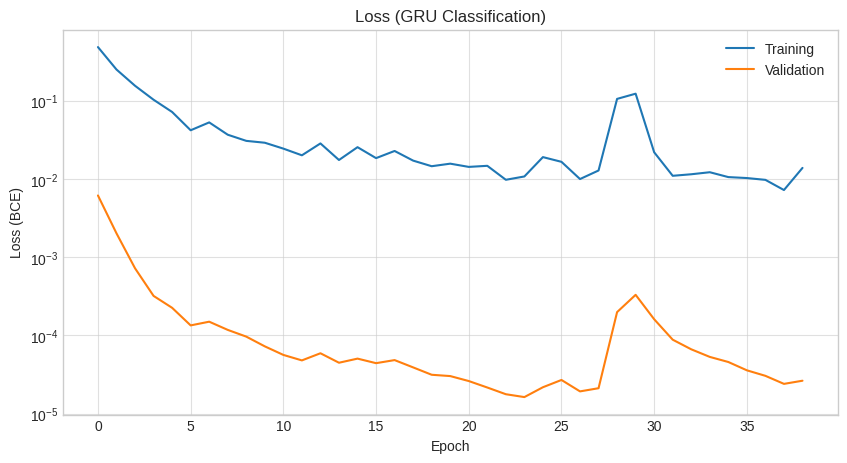


--- Osa 6: Valmis (Luokittelumallin koulutus) ---


In [112]:
# @title 6. Mallin Koulutus (Suoritus) (GRU Luokittelu v1) (2025-04-10 21:42) - Param Varmistus Lisätty

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import traceback
# Varmistetaan luokat ja funktiot varmuuden vuoksi
# Nämä TÄYTYY olla määritelty aiemmissa soluissa (4 ja 5), tarkistetaan myöhemmin
if 'GRUModel' not in locals(): print("VAROITUS: GRUModel luokkaa ei ehkä ole määritelty (Aja Osa 4)"); GRUModel = None
if 'train_model' not in locals(): print("VAROITUS: train_model funktiota ei ehkä ole määritelty (Aja Osa 5)"); train_model = None

print("--- Aloitetaan Mallin Koulutus (Suoritus - LUOKITTELU) ---")

# Alustetaan muuttujat
model = None; model_gru_clf = None; train_losses = None; valid_losses = None
training_run_ok = False
prereqs_ok_for_training = True # Oletus, muutetaan Falseksi jos jokin puuttuu

try:
    # --- Varmista/Määrittele parametrit ja objektit TÄSSÄ SOLUSSA ---
    print("Tarkistetaan/varmistetaan edellytykset...")

    # Datan käsittelystä (Osa 3)
    vars_from_data = ['train_loader', 'valid_loader', 'INPUT_SIZE', 'pos_weight_tensor']
    for var in vars_from_data:
        if var not in locals() or locals()[var] is None:
            print(f"VIRHE: Kriittinen muuttuja Osasta 3 puuttuu: {var}. Aja Osa 3 uudelleen.")
            prereqs_ok_for_training = False
            break # Lopetetaan tarkistus, jos jokin tärkeä puuttuu
    if not prereqs_ok_for_training: raise ValueError("Datan käsittelyn tuloksia puuttuu.")
    input_size = INPUT_SIZE # Otetaan arvo talteen

    # Parametrit (Osa 1)
    if 'RNN_HYPERPARAMS_CLF' not in locals() or RNN_HYPERPARAMS_CLF is None:
        print("VAROITUS: RNN_HYPERPARAMS_CLF ei löytynyt. Määritellään oletusarvot...")
        RNN_HYPERPARAMS_CLF = {'model_type':'GRU', 'input_size':input_size, 'hidden_size':64, 'num_layers':2, 'output_size':1, 'dropout_prob':0.2}
    else: # Varmistetaan tärkeät avaimet ja arvot
        RNN_HYPERPARAMS_CLF.setdefault('hidden_size', 64); RNN_HYPERPARAMS_CLF.setdefault('num_layers', 2);
        RNN_HYPERPARAMS_CLF['output_size'] = 1; RNN_HYPERPARAMS_CLF.setdefault('dropout_prob', 0.2);

    if 'TRAIN_HYPERPARAMS_CLF' not in locals() or TRAIN_HYPERPARAMS_CLF is None:
        print("VAROITUS: TRAIN_HYPERPARAMS_CLF ei löytynyt. Määritellään oletusarvot...")
        TRAIN_HYPERPARAMS_CLF = {'batch_size': 64, 'learning_rate': 0.001, 'epochs': 75, 'patience': 15}
    else: # Varmistetaan avaimet
        TRAIN_HYPERPARAMS_CLF.setdefault('learning_rate', 0.001); TRAIN_HYPERPARAMS_CLF.setdefault('epochs', 75);
        TRAIN_HYPERPARAMS_CLF.setdefault('patience', 15);

    # Laite (Osa 1)
    if 'device' not in locals() or device is None:
         print("VAROITUS: device ei löytynyt. Määritellään uudelleen..."); device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"Laite: {device}")

    # Funktio/Luokkamäärittelyt (Osat 4 & 5)
    if 'GRUModel' not in locals() or GRUModel is None: print("VIRHE: GRUModel-luokkaa ei löytynyt (Aja Osa 4)."); prereqs_ok_for_training = False
    if 'train_model' not in locals() or train_model is None: print("VIRHE: train_model-funktiota ei löytynyt (Aja Osa 5)."); prereqs_ok_for_training = False

    # Haetaan parametrit paikallisiin muuttujiin (jos edellytykset ok)
    if prereqs_ok_for_training:
        hidden_size=RNN_HYPERPARAMS_CLF['hidden_size']; num_layers=RNN_HYPERPARAMS_CLF['num_layers']
        output_size=RNN_HYPERPARAMS_CLF['output_size']; dropout_prob=RNN_HYPERPARAMS_CLF['dropout_prob']
        learning_rate=TRAIN_HYPERPARAMS_CLF['learning_rate']; epochs=TRAIN_HYPERPARAMS_CLF['epochs']; patience=TRAIN_HYPERPARAMS_CLF['patience']
        print("Parametrit ja objektit tarkistettu/varmistettu Osa 6:lle.")
    else:
         raise ValueError("Kaikkia koulutuksen edellytyksiä ei löytynyt.")


    # --- Mallin, häviöfunktion ja optimoijan alustus ---
    model = GRUModel(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
    print(f"Käytetään pos_weightia BCEWithLogitsLossissa: {pos_weight_tensor.item():.4f}")
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("\n--- GRU-Luokittelumalli (ennen koulutusta) ---")
    print(model)
    print(f"Input size: {input_size}, Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print("-------------------------------------------\n")

    # --- Koulutetaan malli ---
    # Kutsu train_model funktiota (jonka pitäisi olla nyt muistissa)
    model, train_losses, valid_losses = train_model(
        model, train_loader, valid_loader, criterion, optimizer, epochs, device, patience
    )

    if model is not None and train_losses is not None and valid_losses is not None:
        print("\nKoulutus suoritettu.")
        model_gru_clf = model # Tallenna onnistunut malli
        training_run_ok = True
        # Piirrä häviökäyrät
        if train_losses and valid_losses:
            plt.figure(figsize=(10, 5)); plt.plot(train_losses, label='Training'); plt.plot(valid_losses, label='Validation')
            plt.title('Loss (GRU Classification)'); plt.xlabel('Epoch'); plt.ylabel('Loss (BCE)')
            try: min_loss=min(min(train_losses,default=1),min(valid_losses,default=1)); plt.yscale('log' if min_loss>1e-7 else 'linear')
            except: plt.yscale('linear')
            plt.legend(); plt.grid(True,alpha=0.6); plt.show()
        else: print("Häviölistoja ei saatu.")
    else:
        print("\nKoulutus epäonnistui train_model-funktion sisällä.")
        model_gru_clf = None


except (NameError, KeyError, AssertionError, ValueError, RuntimeError, TypeError) as e_prereq:
     print(f"\nVIRHE edellytyksissä tai alustuksessa: {e_prereq}")
     traceback.print_exc()
     model_gru_clf = None # Varmista Noneksi
     training_run_ok = False # Merkitse epäonnistuneeksi
except Exception as e_train_run:
     print(f"\nODOTTAMATON VIRHE koulutuksen ajossa: {e_train_run}")
     traceback.print_exc()
     model_gru_clf = None
     training_run_ok = False


# --- VAHVISTUSTULOSTE ---
if training_run_ok and model_gru_clf is not None:
     print("\n--- Osa 6: Valmis (Luokittelumallin koulutus) ---")
else:
     print("\n--- Osa 6: EPÄONNISTUI / OHITETTIIN ---")

In [113]:
# @title 7. Luokittelun Arviointifunktion Määrittely (GRU Luokittelu v1) (2025-04-10 21:50)

import numpy as np
import pandas as pd
import traceback
# Varmistetaan tuonnit
try:
    from sklearn.metrics import (confusion_matrix, classification_report,
                                 roc_auc_score, precision_recall_curve, auc,
                                 accuracy_score) # Lisätään accuracy
    import torch
    from torch.utils.data import DataLoader
    from tqdm.notebook import tqdm
    import matplotlib.pyplot as plt # Kuvaajia varten
except ImportError as e:
    raise ImportError(f"Tarvittava kirjasto puuttuu: {e}")

print("--- Määritellään evaluate_classification_model -funktio ---")
evaluation_functions_ok = False
try:
    def evaluate_classification_model(model, model_name, test_loader, device, decision_threshold=0.5):
        """
        Arvioi binääristä luokittelumallia testidatalla.

        Args:
            model (torch.nn.Module): Koulutettu PyTorch-malli.
            model_name (str): Mallin nimi tulosteisiin.
            test_loader (DataLoader): Testidatan lataaja (tuottaa X, y_true).
            device (torch.device): Laite (cpu tai cuda).
            decision_threshold (float): Kynnysarvo todennäköisyyksille luokittelua varten.

        Returns:
            tuple: Sisältää (all_targets_np, all_predictions_np, all_probabilities_np)
                   tai (None, None, None) jos virhe.
                   Muodot: (num_samples,)
        """
        print(f"\n--- evaluate_classification_model ({model_name}) alkaa ---")
        if model is None: print("Malli puuttuu."); return None, None, None
        if test_loader is None: print("Testilataaja puuttuu."); return None, None, None
        if not (0 < decision_threshold < 1): print("VAROITUS: decision_threshold ei ole välillä (0, 1)."); decision_threshold = 0.5

        model.eval() # Aseta malli arviointitilaan
        all_outputs_list = [] # Kerätään mallin logitit
        all_targets_list = [] # Kerätään todelliset luokat

        print("Ennustetaan todennäköisyyksiä testidatalla...")
        try:
            if len(test_loader.dataset) == 0: print("Testidata on tyhjä."); return None, None, None
            with torch.no_grad():
                # test_loader tuottaa (X_test_tensor, y_test_tensor), missä y on (batch, 1)
                for inputs, targets in tqdm(test_loader, desc=f"Testaus ({model_name})"):
                    inputs = inputs.to(device)
                    # targets ei tarvitse siirtää laitteelle, jos sitä käytetään vain lopussa
                    outputs = model(inputs) # Malli tuottaa logitit, muoto (batch, 1)
                    all_outputs_list.append(outputs.cpu().numpy())
                    all_targets_list.append(targets.cpu().numpy()) # Säilytetään muoto (batch, 1)

            print("Ennusteet kerätty.")
            # Yhdistä kaikki erät
            all_outputs_np = np.concatenate(all_outputs_list, axis=0) # Muoto (total_samples, 1)
            all_targets_np = np.concatenate(all_targets_list, axis=0) # Muoto (total_samples, 1)
            print(f"Kerätty {all_outputs_np.shape[0]} ennustetta/kohdetta.")

            # --- Muunna logitit todennäköisyyksiksi ja ennusteiksi ---
            # Käytä sigmoidia logitteihin -> todennäköisyydet
            # Siirretään takaisin tensoreiksi sigmoidia varten (GPU-tuki)
            with torch.no_grad():
                 all_probabilities_tensor = torch.sigmoid(torch.tensor(all_outputs_np).to(device))
                 all_probabilities_np = all_probabilities_tensor.cpu().numpy() # Muoto (total_samples, 1)

            # Tee binääriset ennusteet kynnysarvon perusteella
            all_predictions_np = (all_probabilities_np >= decision_threshold).astype(int) # Muoto (total_samples, 1)

            # --- Metriikoiden Laskenta ---
            print("\nLasketaan luokittelumetriikat...")
            # Poistetaan viimeinen dimensio metriikoita varten (sklearn odottaa 1D-taulukoita)
            targets_flat = all_targets_np.ravel()
            predictions_flat = all_predictions_np.ravel()
            probabilities_flat = all_probabilities_np.ravel() # Todennäköisyydet AUC:ia varten

            print(f"\n--- {model_name} Luokittelun Arviointi (Kynnys={decision_threshold:.2f}) ---")

            # Sekaannusmatriisi
            print("\nSekaannusmatriisi:")
            cm = confusion_matrix(targets_flat, predictions_flat, labels=[0, 1]) # Määritä luokkien järjestys
            print(pd.DataFrame(cm, index=['Todellinen 0 (EI)', 'Todellinen 1 (KYLLÄ)'],
                               columns=['Ennuste 0', 'Ennuste 1']))

            # Luokitteluraportti
            print("\nLuokitteluraportti:")
            report = classification_report(targets_flat, predictions_flat, target_names=['Luokka 0 (EI)', 'Luokka 1 (KYLLÄ)'], labels=[0, 1], zero_division=0)
            print(report)

            # AUC ROC
            try:
                auc_roc = roc_auc_score(targets_flat, probabilities_flat) # Käytä todennäköisyyksiä
                print(f"\nAUC ROC Score: {auc_roc:.4f}")
            except ValueError as e_auc:
                 # Tämä voi tapahtua, jos testidatassa on vain yhtä luokkaa
                 print(f"VAROITUS: AUC ROC -pisteytystä ei voitu laskea: {e_auc}")
                 auc_roc = None

            # Tulostetaan tärkeimmät metriikat uudelleen selkeyden vuoksi
            TN, FP, FN, TP = cm.ravel()
            recall_class1 = TP / (TP + FN) if (TP + FN) > 0 else 0
            precision_class1 = TP / (TP + FP) if (TP + FP) > 0 else 0
            accuracy = accuracy_score(targets_flat, predictions_flat)
            print("\n--- Yhteenveto ---")
            print(f"  Accuracy:      {accuracy:.4f}")
            print(f"  Recall (Luokka 1 - KYLLÄ): {recall_class1:.4f}  <-- TÄRKEIN?")
            print(f"  Precision (Luokka 1 - KYLLÄ): {precision_class1:.4f}")


            print(f"\n--- evaluate_classification_model ({model_name}) päättyi ---")
            # Palautetaan litistetyt taulukot (1D)
            return targets_flat, predictions_flat, probabilities_flat

        except Exception as e:
            print(f"\n-----> VIRHE evaluate_classification_model ({model_name}) <-----")
            traceback.print_exc(); return None, None, None

    evaluation_functions_ok = True
except NameError as ne: print(f"VIRHE: Tuonti puuttuu: {ne}")
except Exception as e_def: print(f"VIRHE arviointifunktioiden määrittelyssä: {e_def}"); traceback.print_exc()

# --- VAHVISTUSTULOSTE ---
if evaluation_functions_ok:
    print("\n--- Osa 7: Valmis (Luokittelun Arviointifunktiot määritelty) ---")
else:
    print("\n--- Osa 7: EPÄONNISTUI ---")

--- Määritellään evaluate_classification_model -funktio ---

--- Osa 7: Valmis (Luokittelun Arviointifunktiot määritelty) ---


In [114]:
# @title 8. Mallin Arviointi (Suoritus) (GRU Luokittelu v1) (2025-04-10 21:50)

import traceback
import numpy as np # Varmistetaan tuonti
import pandas as pd # Varmistetaan tuonti

print("--- Aloitetaan Mallin Arviointi (Suoritus - LUOKITTELU) ---")

# Alustetaan tulosmuuttujat
true_labels_gru = None
predictions_gru = None
probabilities_gru = None
evaluation_gru_clf_successful = False # Lipuke tälle ajolle

# Tarkistetaan edellytykset
required_eval_vars = ['model_gru_clf', 'test_loader', 'device',
                      'O3_THRESHOLD_8H_AVG', # Vaikka ei suoraan käytetä, hyvä olla kontekstina
                      'evaluate_classification_model'] # Tarkista funktion olemassaolo
missing_eval_vars = []
for var in required_eval_vars:
     if var not in locals() or locals()[var] is None:
          missing_eval_vars.append(var)

if not missing_eval_vars:
    # --- Suoritetaan arviointi ---
    try:
        print("\nKutsutaan evaluate_classification_model...")
        # Aseta päätöksentekokynnys (yleensä 0.5, voit kokeilla säätää tätä myöhemmin)
        DECISION_THRESHOLD = 0.95

        # Käytetään Osassa 6 tallennettua model_gru_clf -mallia
        true_labels_gru, predictions_gru, probabilities_gru = evaluate_classification_model(
            model=model_gru_clf,
            model_name="GRU (Laaj. FE - Luokittelu)",
            test_loader=test_loader,
            device=device,
            decision_threshold=DECISION_THRESHOLD
        )

        # Tarkistetaan paluuarvot
        if true_labels_gru is not None and predictions_gru is not None and probabilities_gru is not None:
            print("\nLuokittelun arviointifunktion ajo suoritettu.")
            # Tarkistetaan tyypit ja pituudet
            if isinstance(true_labels_gru, np.ndarray) and isinstance(predictions_gru, np.ndarray) and isinstance(probabilities_gru, np.ndarray) \
               and len(true_labels_gru) == len(predictions_gru) == len(probabilities_gru) and len(true_labels_gru) > 0:
                 print(f"Arviointi palautti validit tulokset ({len(true_labels_gru)} kpl).")
                 evaluation_gru_clf_successful = True
            else:
                 print("VIRHE: Arviointifunktion palautukset eivät ole odotettuja numpy arrayta tai pituudet eivät täsmää.")
                 true_labels_gru, predictions_gru, probabilities_gru = None, None, None # Nollataan
        else:
            print("\nLuokittelun arviointi epäonnistui (funktio palautti None).")

    except Exception as e:
        print(f"\nVIRHE luokittelun arvioinnin suorituksessa: {e}")
        traceback.print_exc()
        true_labels_gru, predictions_gru, probabilities_gru = None, None, None

else:
    print(f"\nArviointia ei voida suorittaa, koska yksi tai useampi tarvittava edellytys puuttuu: {missing_eval_vars}")
    true_labels_gru, predictions_gru, probabilities_gru = None, None, None


# --- VAHVISTUSTULOSTE ---
if evaluation_gru_clf_successful:
     print("\n--- Osa 8: Valmis (Luokittelumallin arviointi) ---")
else:
     print("\n--- Osa 8: EPÄONNISTUI / OHITETTIIN ---")

--- Aloitetaan Mallin Arviointi (Suoritus - LUOKITTELU) ---

Kutsutaan evaluate_classification_model...

--- evaluate_classification_model (GRU (Laaj. FE - Luokittelu)) alkaa ---
Ennustetaan todennäköisyyksiä testidatalla...


Testaus (GRU (Laaj. FE - Luokittelu)):   0%|          | 0/20 [00:00<?, ?it/s]

Ennusteet kerätty.
Kerätty 1218 ennustetta/kohdetta.

Lasketaan luokittelumetriikat...

--- GRU (Laaj. FE - Luokittelu) Luokittelun Arviointi (Kynnys=0.95) ---

Sekaannusmatriisi:
                      Ennuste 0  Ennuste 1
Todellinen 0 (EI)          1166         26
Todellinen 1 (KYLLÄ)          0         26

Luokitteluraportti:
                  precision    recall  f1-score   support

   Luokka 0 (EI)       1.00      0.98      0.99      1192
Luokka 1 (KYLLÄ)       0.50      1.00      0.67        26

        accuracy                           0.98      1218
       macro avg       0.75      0.99      0.83      1218
    weighted avg       0.99      0.98      0.98      1218


AUC ROC Score: 0.9981

--- Yhteenveto ---
  Accuracy:      0.9787
  Recall (Luokka 1 - KYLLÄ): 1.0000  <-- TÄRKEIN?
  Precision (Luokka 1 - KYLLÄ): 0.5000

--- evaluate_classification_model (GRU (Laaj. FE - Luokittelu)) päättyi ---

Luokittelun arviointifunktion ajo suoritettu.
Arviointi palautti validit tulokset (12

In [115]:
# @title Tarkista 120 µg/m³ ylitysten määrä datassa

import pandas as pd
import numpy as np
# Varmistetaan tqdm tuonti
try: from tqdm.notebook import tqdm
except ImportError: tqdm = lambda x, **kwargs: x

print(f"--- Tarkistetaan 8h keskiarvon > 120 µg/m³ ylitysten määrä ---")
print(f"(Käytetään kynnysarvoa: 120 µg/m³)")

# Varmistetaan tarvittavat muuttujat ja funktio edellisistä soluista
if 'df_raw_full' in locals() and df_raw_full is not None and \
   'TARGET_COLUMN_REGRESSION' in locals() and TARGET_COLUMN_REGRESSION in df_raw_full.columns and \
   'PREDICTION_HORIZON' in locals() and PREDICTION_HORIZON is not None and \
   'calculate_binary_target' in locals() and callable(calculate_binary_target):

    try:
        threshold_to_check = 120
        print(f"\nKäytetään dataa aikaväliltä: {df_raw_full.index.min()} - {df_raw_full.index.max()}")
        print(f"Lasketaan kohdeluokka kynnyksellä {threshold_to_check} µg/m³...")

        # Kutsutaan funktiota koko datalle (ennen FE:n aiheuttamaa datan lyhenemistä)
        # Funktio itse tulostaa jakauman ja summan
        binary_target_120 = calculate_binary_target(
            ozone_series=df_raw_full[TARGET_COLUMN_REGRESSION],
            horizon=PREDICTION_HORIZON,
            threshold=threshold_to_check, # Käytetään 120 rajaa
            rolling_window=8
        )

        if binary_target_120 is None:
             print("Kohdeluokan laskenta epäonnistui.")
        # Funktio tulosti jo tarvittavat tiedot, mutta lisätään selkeä yhteenveto
        elif len(binary_target_120) > 0:
            total_calculated = len(binary_target_120)
            total_exceedances = binary_target_120.sum()
            percentage_exceedances = binary_target_120.mean() * 100
            print("\n---> Yhteenveto (koko data, jolle kohde laskettiin):")
            print(f"   Kohdeluokka laskettu {total_calculated} tunnille.")
            print(f"   Kertaa, jolloin max 8h ka > {threshold_to_check} µg/m³ seuraavan 24h aikana: {total_exceedances} ({percentage_exceedances:.2f}%)")
        else:
            print("Kohdesarja jäi tyhjäksi laskennan jälkeen.")

    except Exception as e:
        print(f"Virhe tarkistuksen aikana: {e}")
        import traceback
        traceback.print_exc()

else:
    # Tulostetaan selkeämmin, mikä puuttuu
    missing_check = []
    if 'df_raw_full' not in locals() or df_raw_full is None: missing_check.append('df_raw_full')
    if 'TARGET_COLUMN_REGRESSION' not in locals(): missing_check.append('TARGET_COLUMN_REGRESSION')
    if 'PREDICTION_HORIZON' not in locals() or PREDICTION_HORIZON is None: missing_check.append('PREDICTION_HORIZON')
    if 'calculate_binary_target' not in locals() or not callable(calculate_binary_target): missing_check.append('calculate_binary_target function')
    print(f"Tarvittavia muuttujia/funktioita puuttuu: {missing_check}")
    print("Aja solut 1, 2 ja 3 uudelleen.")

--- Tarkistetaan 8h keskiarvon > 120 µg/m³ ylitysten määrä ---
(Käytetään kynnysarvoa: 120 µg/m³)

Käytetään dataa aikaväliltä: 2024-04-01 00:00:00+03:00 - 2025-04-01 23:00:00+03:00
Lasketaan kohdeluokka kynnyksellä 120 µg/m³...

Lasketaan binääristä kohdemuuttujaa (8h ka > 120 seuraavan 24h aikana)...
Iteroidaan aikasarjaa kohdeluokkien määrittämiseksi...


Lasketaan kohdeluokkia:   0%|          | 0/8757 [00:00<?, ?it/s]

Binäärinen kohde laskettu 8757 pisteelle.
Luokkajakauma (0=Ei Ylitystä, 1=Ylitys): 
0    0.9971
1    0.0029
Name: proportion, dtype: float64
Ylityksiä yhteensä: 25

---> Yhteenveto (koko data, jolle kohde laskettiin):
   Kohdeluokka laskettu 8757 tunnille.
   Kertaa, jolloin max 8h ka > 120 µg/m³ seuraavan 24h aikana: 25 (0.29%)


In [116]:
# @title 9. Viimeisimmän Ennustejakson Huippuarvo (GRU Luokittelu v1) (2025-04-10 21:55)

print("\n--- Osa 9: Viimeisimmän Ennustejakson Huippuarvo ---")
print("Tämä osio ei ole relevantti luokittelumallille, joka ennustaa Kyllä/Ei.")
print("Siirrytään visualisointiin (Osa 10).")
print("\n--- Osa 9: Ohitettu ---")


--- Osa 9: Viimeisimmän Ennustejakson Huippuarvo ---
Tämä osio ei ole relevantti luokittelumallille, joka ennustaa Kyllä/Ei.
Siirrytään visualisointiin (Osa 10).

--- Osa 9: Ohitettu ---



--- Osa 10: Visualisointi (Luokittelutulokset) ---

Arviointi onnistui, piirretään luokittelukuvaajat...


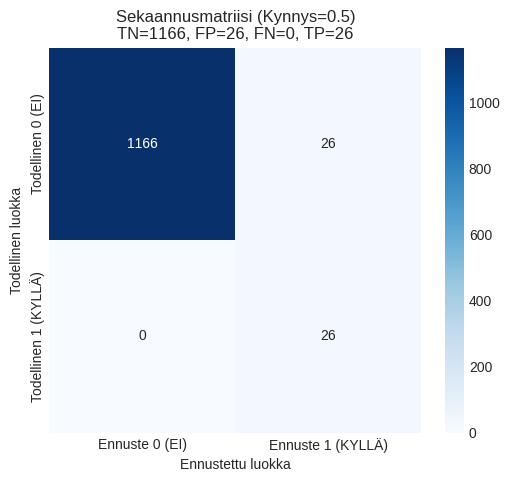

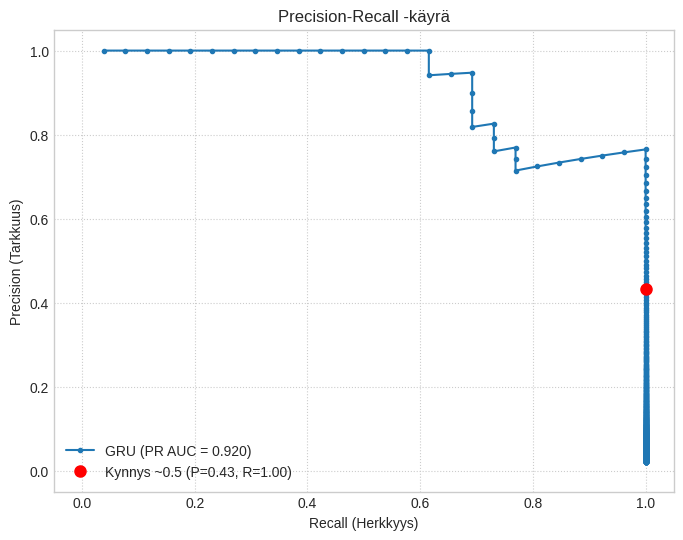

PR-käyrä näyttää tarkkuuden ja herkkyyden välisen kompromissin eri päätöskynnyksillä.
Parempi malli on lähempänä oikeaa yläkulmaa (Precision=1, Recall=1).
Punainen piste näyttää nykyisen 0.5 kynnyksen sijainnin.
Harkitse, olisiko jokin muu piste käyrällä (eri kynnysarvo) parempi kompromissi.

--- Osa 10: Valmis ---

--- Koko skriptin ajo päättyi ---
Kokonaisajoaika: 17.33 sekuntia.


In [117]:
# @title 10. Visualisointi (Luokittelutulokset) (GRU v4 - Laaj. FE) (2025-04-10 22:16) # Päivitetty aika

import matplotlib.pyplot as plt # Varmista tuonti
import numpy as np # Varmista tuonti
import pandas as pd # Varmista tuonti
import traceback
import seaborn as sns # Tuodaan heatmapia varten
# Varmistetaan sklearn-tuonnit
try:
    from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
except ImportError:
    print("VIRHE: Sklearn-metriikoiden tuonti epäonnistui!")
    raise

print("\n--- Osa 10: Visualisointi (Luokittelutulokset) ---")
visualization_possible = False

# Tarkistetaan edellytykset (Osa 8:n onnistuminen ja tulosmuuttujat)
# Käytetään _gru päätteisiä muuttujia
if 'evaluation_gru_clf_successful' in locals() and evaluation_gru_clf_successful and \
   'true_labels_gru' in locals() and isinstance(true_labels_gru, np.ndarray) and \
   'predictions_gru' in locals() and isinstance(predictions_gru, np.ndarray) and \
   'probabilities_gru' in locals() and isinstance(probabilities_gru, np.ndarray):

    print("\nArviointi onnistui, piirretään luokittelukuvaajat...")
    # Varmistetaan, ettei data ole tyhjää
    if len(true_labels_gru) > 0 and len(true_labels_gru) == len(predictions_gru) == len(probabilities_gru):
        visualization_possible = True
        try: # --- Kuvaaja 1: Sekaannusmatriisi Heatmap ---
            plt.figure(figsize=(6, 5))
            # Lasketaan CM uudelleen tässä, jotta solu on itsenäisempi
            cm = confusion_matrix(true_labels_gru, predictions_gru, labels=[0, 1])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Ennuste 0 (EI)', 'Ennuste 1 (KYLLÄ)'],
                        yticklabels=['Todellinen 0 (EI)', 'Todellinen 1 (KYLLÄ)'])
            plt.ylabel('Todellinen luokka')
            plt.xlabel('Ennustettu luokka')
            TN, FP, FN, TP = cm.ravel()
            plt.title(f'Sekaannusmatriisi (Kynnys=0.5)\nTN={TN}, FP={FP}, FN={FN}, TP={TP}')
            plt.show()

        except Exception as e_cm:
            print(f"VIRHE Sekaannusmatriisin piirrossa: {e_cm}"); traceback.print_exc(); visualization_possible = False # Merkitse epäonnistuneeksi

        try: # --- Kuvaaja 2: Precision-Recall -käyrä ---
            # Käytetään todennäköisyyksiä käyrän piirtoon
            precision_curve, recall_curve, thresholds_pr = precision_recall_curve(true_labels_gru, probabilities_gru)
            pr_auc = auc(recall_curve, precision_curve)

            plt.figure(figsize=(8, 6))
            # Poistetaan viimeinen piste käyristä (vastaa kynnystä > 1)
            plt.plot(recall_curve[:-1], precision_curve[:-1], marker='.', label=f'GRU (PR AUC = {pr_auc:.3f})')

            # Etsitään piste, joka on lähimpänä kynnystä 0.5
            # Huom: thresholds_pr ei sisällä arvoa 1.0, joka vastaa viimeistä pistettä
            close_threshold_idx = np.argmin(np.abs(thresholds_pr - 0.5))

            # Piirretään piste kynnystä 0.5 vastaavalle kohdalle käyrällä
            plt.plot(recall_curve[close_threshold_idx], precision_curve[close_threshold_idx], 'o', markersize=8,
                     label=f'Kynnys ~0.5 (P={precision_curve[close_threshold_idx]:.2f}, R={recall_curve[close_threshold_idx]:.2f})', color="red")

            plt.xlabel('Recall (Herkkyys)')
            plt.ylabel('Precision (Tarkkuus)')
            plt.title('Precision-Recall -käyrä')
            plt.legend()
            plt.grid(True, linestyle=':')
            plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05]) # Akselien rajat
            plt.show()
            print("PR-käyrä näyttää tarkkuuden ja herkkyyden välisen kompromissin eri päätöskynnyksillä.")
            print("Parempi malli on lähempänä oikeaa yläkulmaa (Precision=1, Recall=1).")
            print("Punainen piste näyttää nykyisen 0.5 kynnyksen sijainnin.")
            print("Harkitse, olisiko jokin muu piste käyrällä (eri kynnysarvo) parempi kompromissi.")

        except Exception as e_prc:
            print(f"VIRHE Precision-Recall -käyrän piirrossa: {e_prc}"); traceback.print_exc(); visualization_possible = False

    else:
        print("Visualisointia ei voida suorittaa, koska arvioinnin tulosdata on tyhjää tai pituudet eivät täsmää.")
else:
     print("\nVisualisointia ei suoriteta, koska arviointi epäonnistui / tarvittavia muuttujia puuttuu.")

# --- VAHVISTUSTULOSTE ---
if visualization_possible:
    print("\n--- Osa 10: Valmis ---")
else:
    print("\n--- Osa 10: EPÄONNISTUI / OHITETTIIN ---")

# --- LOPPUTULOSTE ---
print(f"\n--- Koko skriptin ajo päättyi ---")
script_end_time = time.time()
if 'script_start_time' in locals() and script_start_time is not None:
     try: print(f"Kokonaisajoaika: {script_end_time - script_start_time:.2f} sekuntia.")
     except: print("Ajoaikaa ei voitu laskea.")
else: print("Kokonaisajoaikaa ei voitu laskea.")